In [1]:
import os, time, json, zipfile, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception as e:
    print("xgboost not found; will skip XGBClassifier:", e)
    HAS_XGB = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); 
if device == 'cuda':
    torch.cuda.manual_seed_all(SEED)

batch_size = 32
num_epochs = 20   
learning_rate = 1e-3
patience = 5
num_workers = 2 if os.name != 'nt' else 0

save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)
best_ckpt_path = os.path.join(save_dir, "best_cnn.pt")

Using device: cuda


In [2]:
import kagglehub

path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/


In [3]:
data_root = os.path.join(path, "color")  
assert os.path.isdir(data_root), f"Expected folder not found: {data_root}"

for cls in sorted(os.listdir(data_root))[:10]:
    cls_path = os.path.join(data_root, cls)
    if os.path.isdir(cls_path):
        n = sum(1 for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path,f)))
        print(f"{cls}: {n} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images


In [4]:
IMG_SIZE = 224
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  
])

transform_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [5]:
full_dataset = datasets.ImageFolder(root=data_root, transform=transform_train)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", num_classes)

N = len(full_dataset)
idxs = np.arange(N)
train_idx, tmp_idx = train_test_split(idxs, test_size=0.30, stratify=[full_dataset.targets[i] for i in idxs], random_state=SEED)
val_idx, test_idx = train_test_split(tmp_idx, test_size=0.50, stratify=[full_dataset.targets[i] for i in tmp_idx], random_state=SEED)

class TransformSubset(Subset):
    def __init__(self, dataset, indices, transform):
        super().__init__(dataset, indices)
        self.transform = transform
        self.base_dataset = dataset
    def __getitem__(self, idx):
        x, y = super().__getitem__(idx)
        
        img_path, label = self.base_dataset.samples[self.indices[idx]]
        from PIL import Image
        with Image.open(img_path) as im:
            im = im.convert("RGB")
            x = self.transform(im)
        return x, label

train_ds = TransformSubset(full_dataset, train_idx, transform_train)
val_ds   = TransformSubset(full_dataset, val_idx, transform_eval)
test_ds  = TransformSubset(full_dataset, test_idx, transform_eval)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device=='cuda'))
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device=='cuda'))
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device=='cuda'))

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

Classes: 38
Train/Val/Test sizes: 38013/8146/8146


In [6]:
class SelfAttention2D(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key   = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.shape
        q = self.query(x).view(B, C//8, -1)
        k = self.key(x).view(B, C//8, -1)
        v = self.value(x).view(B, C, -1)
        attn = torch.bmm(q.permute(0,2,1), k)
        attn = torch.softmax(attn / (C**0.5), dim=-1)
        out = torch.bmm(v, attn.permute(0,2,1))
        out = out.view(B, C, H, W)
        out = self.gamma * out + x
        return out

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            SelfAttention2D(64),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

    def get_embedding(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

model = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [7]:
class EarlyStopping:
    def __init__(self, patience=5, mode='min', min_delta=1e-4):
        self.patience = patience
        self.mode = mode  
        self.min_delta = float(min_delta)
        self.best = None
        self.num_bad = 0
        self.should_stop = False

    def step(self, metric):
        if self.best is None:
            self.best = metric
            return False

        if self.mode == 'min':
            improve = (metric < self.best - self.min_delta)
        else:  # mode == 'max'
            improve = (metric > self.best + self.min_delta)

        if improve:
            self.best = metric
            self.num_bad = 0
        else:
            self.num_bad += 1
            if self.num_bad >= self.patience:
                self.should_stop = True
        return self.should_stop

In [8]:
train_losses, val_losses = [], []

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, leave=False):
        images = images.to(device)
        labels = labels.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        use_amp = 'scaler' in globals() and scaler is not None and str(device) == "cuda"
        if use_amp:
            from torch.amp import autocast
            with autocast(device_type="cuda", enabled=True):
                logits = model(images)
                loss = criterion(logits, labels)
        else:
            logits = model(images)
            loss = criterion(logits, labels)

        if train:
            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

        batch_sz = images.size(0)
        epoch_loss += loss.item() * batch_sz
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += batch_sz

    return epoch_loss / max(1, total), correct / max(1, total)



epoch_times = []
total_train_time_sec = None
avg_epoch_time_sec = None

def train_model(num_epochs=50, patience=2, min_delta=0.003):

    es = EarlyStopping(patience=patience, mode='min', min_delta=min_delta)
    best_val = float('inf')
    global total_train_time_sec, avg_epoch_time_sec, epoch_times
    epoch_times = []
    t0_total = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        t0_epoch = time.time()
        tr_loss, tr_acc = run_epoch(train_loader, train=True)
        vl_loss, vl_acc = run_epoch(val_loader,   train=False)
        epoch_times.append(time.time() - t0_epoch)

        train_losses.append(tr_loss)
        val_losses.append(vl_loss)

        print(f"  train loss={tr_loss:.4f} acc={tr_acc:.4f} | val loss={vl_loss:.4f} acc={vl_acc:.4f}")
        if vl_loss < best_val - min_delta:
            best_val = vl_loss
            torch.save(model.state_dict(), best_ckpt_path)
            print("  -> saved best checkpoint")

        if es.step(vl_loss):
            print("Early stopping triggered.")
            break

    total_train_time_sec = time.time() - t0_total
    avg_epoch_time_sec = (sum(epoch_times) / len(epoch_times)) if epoch_times else None
    print(f"Total training time: {total_train_time_sec:.2f} s")
    if avg_epoch_time_sec is not None:
        print(f"Average epoch time: {avg_epoch_time_sec:.2f} s")



train_model(num_epochs=num_epochs, patience=2, min_delta=0.003)
model.load_state_dict(torch.load(best_ckpt_path, map_location=device))
model.eval()


Epoch 1/20


  train loss=2.2952 acc=0.3618 | val loss=1.3307 acc=0.5986
  -> saved best checkpoint
Epoch 2/20


  train loss=1.0645 acc=0.6755 | val loss=0.6653 acc=0.7935
  -> saved best checkpoint
Epoch 3/20


  train loss=0.6829 acc=0.7876 | val loss=0.4487 acc=0.8582
  -> saved best checkpoint
Epoch 4/20


  train loss=0.5082 acc=0.8388 | val loss=0.3255 acc=0.8957
  -> saved best checkpoint
Epoch 5/20


  train loss=0.3961 acc=0.8727 | val loss=0.2851 acc=0.9065
  -> saved best checkpoint
Epoch 6/20


  train loss=0.3267 acc=0.8945 | val loss=0.2089 acc=0.9365
  -> saved best checkpoint
Epoch 7/20


  train loss=0.2752 acc=0.9098 | val loss=0.2113 acc=0.9327
Epoch 8/20


  train loss=0.2392 acc=0.9228 | val loss=0.1580 acc=0.9468
  -> saved best checkpoint
Epoch 9/20


  train loss=0.2169 acc=0.9301 | val loss=0.2023 acc=0.9352
Epoch 10/20


  train loss=0.1963 acc=0.9355 | val loss=0.1336 acc=0.9547
  -> saved best checkpoint
Epoch 11/20


  train loss=0.1756 acc=0.9426 | val loss=0.1415 acc=0.9548
Epoch 12/20


  train loss=0.1618 acc=0.9464 | val loss=0.1004 acc=0.9696
  -> saved best checkpoint
Epoch 13/20


  train loss=0.1424 acc=0.9507 | val loss=0.1056 acc=0.9658
Epoch 14/20


  train loss=0.1400 acc=0.9542 | val loss=0.1113 acc=0.9618
Early stopping triggered.
Total training time: 2553.73 s
Average epoch time: 182.40 s


CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): SelfAttention2D(
      (query): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (key): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (value): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 256, kernel_s

In [9]:
@torch.no_grad()
def extract_embeddings(loader):
    model.eval()
    feats = []
    labs = []
    for images, labels in tqdm(loader, leave=False):
        images = images.to(device)
        emb = model.get_embedding(images).cpu().numpy()
        feats.append(emb)
        labs.append(labels.numpy())
    X = np.concatenate(feats, axis=0)
    y = np.concatenate(labs, axis=0)
    return X, y

X_train, y_train = extract_embeddings(train_loader)
X_val,   y_val   = extract_embeddings(val_loader)
X_test,  y_test  = extract_embeddings(test_loader)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


t0_inf = time.time()
X_test,  y_test  = extract_embeddings(test_loader)  
test_total_inference_time_sec = time.time() - t0_inf
avg_inference_time_per_image_sec = test_total_inference_time_sec / max(1, len(test_ds))
print(f"Total test inference time: {test_total_inference_time_sec:.2f} s for {len(test_ds)} images")
print(f"Average per-image inference time: {avg_inference_time_per_image_sec*1000:.2f} ms")


Shapes: (38013, 256) (8146, 256) (8146, 256)


Total test inference time: 17.56 s for 8146 images
Average per-image inference time: 2.16 ms


In [10]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

In [11]:
rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=None, 
    n_jobs=-1, 
    random_state=SEED
)

knn = KNeighborsClassifier(
    n_neighbors=5, 
    weights='distance', 
    metric='minkowski'
)

svm = SVC(
    C=10.0, 
    kernel='rbf', 
    gamma='scale', 
    probability=True, 
    random_state=SEED
)

if HAS_XGB:
    xgb = XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='hist',
        objective='multi:softprob',
        num_class=num_classes,
        random_state=SEED,
        n_jobs=-1
    )
else:
    xgb = None

base_estimators = [
    ('rf', rf),
    ('knn', knn),
    ('svm', svm),
]
if xgb is not None:
    base_estimators.append(('xgb', xgb))

print("Base estimators:", [k for k,_ in base_estimators])

Base estimators: ['rf', 'knn', 'svm', 'xgb']


In [12]:
def fit_and_report(clf, name, Xtr, ytr, Xte, yte):
    t0 = time.time()
    clf.fit(Xtr, ytr)
    dt = time.time() - t0
    preds = clf.predict(Xte)
    acc = accuracy_score(yte, preds)
    print(f"[{name}] test acc={acc:.4f} | fit_time={dt:.1f}s")
    print(classification_report(yte, preds, target_names=class_names, digits=4))
    return acc, preds

results = {}
preds_bank = {}

for name, clf in base_estimators:
    acc, preds = fit_and_report(clf, name, X_train_s, y_train, X_test_s, y_test)
    results[name] = acc
    preds_bank[name] = preds

print("Base classifier accuracies:", results)

[rf] test acc=0.9840 | fit_time=67.8s
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9677    0.9574    0.9626        94
                                 Apple___Black_rot     0.9892    0.9892    0.9892        93
                          Apple___Cedar_apple_rust     1.0000    0.9756    0.9877        41
                                   Apple___healthy     0.9757    0.9797    0.9777       246
                               Blueberry___healthy     0.9825    0.9956    0.9890       226
          Cherry_(including_sour)___Powdery_mildew     0.9936    0.9873    0.9905       158
                 Cherry_(including_sour)___healthy     0.9844    0.9844    0.9844       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9577    0.8831    0.9189        77
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000       179
               Corn_(maize)___Northern_Le

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def oof_proba(base_clf, X, y, X_test):
    n_classes = len(np.unique(y))
    oof = np.zeros((X.shape[0], n_classes), dtype=np.float32)
    test_preds = []
    for train_idx, valid_idx in skf.split(X, y):
        X_tr, X_va = X[train_idx], X[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]
        clf = base_clf
        clf.fit(X_tr, y_tr)
        if hasattr(clf, "predict_proba"):
            oof[valid_idx] = clf.predict_proba(X_va)
            test_preds.append(clf.predict_proba(X_test))
        else:
            dec_va = clf.decision_function(X_va)
            dec_te = clf.decision_function(X_test)
            def softmax(z):
                z = z - z.max(axis=1, keepdims=True)
                ez = np.exp(z); return ez/ez.sum(axis=1, keepdims=True)
            oof[valid_idx] = softmax(dec_va)
            test_preds.append(softmax(dec_te))
    test_mean = np.mean(test_preds, axis=0)
    return oof, test_mean

train_meta_list = []
test_meta_list  = []

for name, base in base_estimators:
    print(f"OOF for {name}")
    oof_tr, te_mean = oof_proba(base, X_train_s, y_train, X_test_s)
    train_meta_list.append(oof_tr)
    test_meta_list.append(te_mean)

X_train_meta = np.concatenate(train_meta_list, axis=1)
X_test_meta  = np.concatenate(test_meta_list, axis=1)

print("Meta shape:", X_train_meta.shape, X_test_meta.shape)

OOF for rf
OOF for knn
OOF for svm
OOF for xgb
Meta shape: (38013, 152) (8146, 152)


In [14]:
meta = LogisticRegression(max_iter=2000, multi_class='multinomial')
meta.fit(X_train_meta, y_train)
meta_preds = meta.predict(X_test_meta)
meta_acc = accuracy_score(y_test, meta_preds)
print(f"[STACKING] test acc={meta_acc:.4f}")
print(classification_report(y_test, meta_preds, target_names=class_names, digits=4))

cm = confusion_matrix(y_test, meta_preds)
print("Confusion Matrix (Stacking):\n", cm)


[STACKING] test acc=0.9905
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9479    0.9681    0.9579        94
                                 Apple___Black_rot     1.0000    1.0000    1.0000        93
                          Apple___Cedar_apple_rust     1.0000    0.9756    0.9877        41
                                   Apple___healthy     0.9837    0.9837    0.9837       246
                               Blueberry___healthy     0.9956    0.9956    0.9956       226
          Cherry_(including_sour)___Powdery_mildew     0.9937    1.0000    0.9968       158
                 Cherry_(including_sour)___healthy     0.9921    0.9844    0.9882       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9103    0.9221    0.9161        77
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000       179
               Corn_(maize)___Northern_Leaf_Blight  

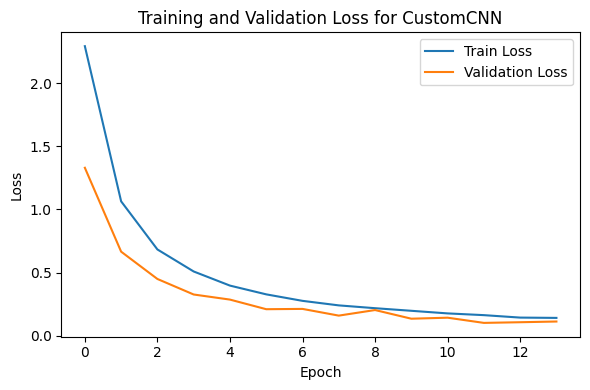

ROC plot skipped: No trained classifier found for ROC plotting.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

try:
    if 'train_losses' in globals() and 'val_losses' in globals() and len(train_losses) and len(val_losses):
        plt.figure(figsize=(6, 4))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title("Training and Validation Loss for CustomCNN")
        plt.tight_layout()
        plt.show()
    else:
        print("Loss plot skipped: train_losses/val_losses are empty or undefined.")
except Exception as e:
    print("Loss plot skipped:", e)

try:
    candidates = []
    try:
        if 'xgb_clf' in globals() and xgb_clf is not None:
            candidates.append(('XGBoost', xgb_clf))
    except Exception:
        pass
    if 'stack_clf_lr' in globals():
        candidates.append(('STACKING (LR meta)', stack_clf_lr))
    if 'rf_clf' in globals():
        candidates.append(('RandomForest', rf_clf))
    if 'svm_clf' in globals():
        candidates.append(('SVM (RBF)', svm_clf))
    if 'knn_clf' in globals():
        candidates.append(('k-NN', knn_clf))

    if not candidates:
        raise RuntimeError("No trained classifier found for ROC plotting.")

    name, clf = None, None
    for nm, c in candidates:
        try:
            _ = proba(c, X_test)
            name, clf = nm, c
            break
        except Exception:
            continue
    if clf is None:
        raise RuntimeError("No candidate classifier could produce probabilities.")

    P = proba(clf, X_test)
    n_classes = P.shape[1]

    if 'Y_test_ovr' in globals() and getattr(Y_test_ovr, 'shape', (0,0))[1] == n_classes:
        Y_bin = Y_test_ovr
    else:
        Y_bin = label_binarize(y_test, classes=np.arange(n_classes))

    labels_for_plot = class_names if 'class_names' in globals() and len(class_names) == n_classes \
                      else [f"class_{i}" for i in range(n_classes)]

    plt.figure(figsize=(7, 6))
    roc_aucs = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(Y_bin[:, i], P[:, i])
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        plt.plot(fpr, tpr, label=f"{labels_for_plot[i]} (AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves (OvR) — {name} on Test")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("ROC plot skipped:", e)


In [16]:
summary = {
    "base_classifier_acc": {k: float(v) for k, v in results.items()},
    "stacking_acc": float(meta_acc),
    "classes": class_names,
    "shapes": {
        "X_train": X_train.shape,
        "X_val": X_val.shape,
        "X_test": X_test.shape,
        "X_train_meta": X_train_meta.shape,
        "X_test_meta": X_test_meta.shape
    },
    "params": {
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "patience": patience
    }
}
with open("ensemble_stacking_summary.json","w") as f:
    json.dump(summary, f, indent=2)
print(json.dumps(summary, indent=2))


{
  "base_classifier_acc": {
    "rf": 0.9840412472379082,
    "knn": 0.9761846304934937,
    "svm": 0.9885833537932728,
    "xgb": 0.9833046894181193
  },
  "stacking_acc": 0.9905475079793764,
  "classes": [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry_(including_sour)___Powdery_mildew",
    "Cherry_(including_sour)___healthy",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot",
    "Peach___healthy",
    "Pepper,_bell___Bacterial_spot",
    "Pepper,_bell___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Raspberry___hea

In [17]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-45gcl9iz
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-45gcl9iz
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

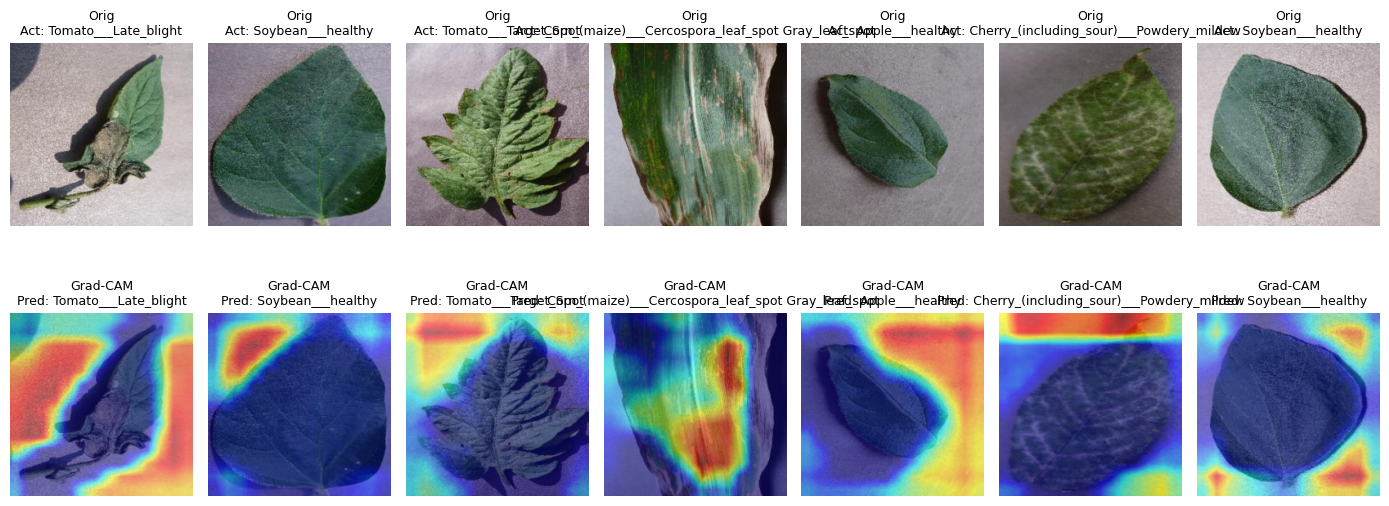

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

mean = np.array([0.0, 0.0, 0.0], dtype=np.float32)
std  = np.array([1.0, 1.0, 1.0], dtype=np.float32)

def get_last_conv_layer(m: nn.Module) -> nn.Module:
    convs = [mod for mod in m.modules() if isinstance(mod, nn.Conv2d)]
    if not convs:
        raise ValueError("No Conv2d layers found in the model; Grad-CAM needs a conv layer.")
    return convs[-1]

last_conv = get_last_conv_layer(model)
target_layers = [last_conv]

model.eval().to(device)

n_show = min(7, len(test_ds))

with GradCAM(model=model, target_layers=target_layers) as cam:
    plt.figure(figsize=(14, 6))
    for idx in range(n_show):
        img_tensor, label = test_ds[idx]
        img_tensor = img_tensor.unsqueeze(0).to(device)

        img_np = img_tensor[0].detach().cpu().permute(1, 2, 0).numpy().astype(np.float32)
        original = np.clip(img_np * std + mean, 0.0, 1.0)

        with torch.no_grad():
            logits = model(img_tensor)
        pred_cls = int(logits.argmax(dim=1).item())

        targets = [ClassifierOutputTarget(pred_cls)]
        grayscale_cam = cam(input_tensor=img_tensor, targets=targets, eigen_smooth=True)
        heatmap = grayscale_cam[0]
        overlay = show_cam_on_image(original, heatmap, use_rgb=True)

        plt.subplot(2, n_show, idx + 1)
        act_name = class_names[label] if "class_names" in globals() else str(label)
        plt.imshow(original)
        plt.title(f"Orig\nAct: {act_name}", fontsize=9)
        plt.axis('off')

        plt.subplot(2, n_show, n_show + idx + 1)
        pred_name = class_names[pred_cls] if "class_names" in globals() else str(pred_cls)
        plt.imshow(overlay)
        plt.title(f"Grad-CAM\nPred: {pred_name}", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
